In [ ]:
!pip install pandas
!pip install SPARQLWrapper
!pip install geopandas
!pip install matplotlib

In [238]:
import pandas as pd
import geopandas as gpd
from SPARQLWrapper import SPARQLWrapper, JSON
import requests
import json
import numpy as np

# Daten daden

## Zürcherstrassen von Wikidata

In [106]:
def createQuery():
    
    wdUrl = "https://query.wikidata.org/sparql"
    user_agent = 'Streetnamequery/1.0 (https://github.com/CaptainInler/equalstreetnames-zurich-QS)'
    sparql = SPARQLWrapper(wdUrl, agent=user_agent)
    
    #print(wdKey)
    query = """
    SELECT ?nativename ?streetkey WHERE {
                    ?streetname wdt:P1945 ?streetkey;
                    wdt:P131 wd:Q72;
                    wdt:P1705 ?nativename.
                    SERVICE wikibase:label { bd:serviceParam wikibase:language "de" . } 
                    }
    """
    #print(query)
    
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql

In [107]:
sparql = createQuery()

In [108]:
results = ""

try:
    results = sparql.query()
    #print(results.info())
except HTTPError as e:
    print(f"{i} Anfragen ausgeführt")
    #Prüfen auf Statuscode 429 (Too many Requests)
    if e.status == 429:
        print(f'Statuscode 429 aufgetreten: Neu Anfrage in {e.headers.get("retry-after")}sec möglich')
        sleep(int(e.headers.get("retry-after"))+2)
    else:
        raise
        
result = results.convert()
#print(result)
wikidf = pd.json_normalize(result['results']['bindings'])

In [109]:
wikidf.head()

,streetkey.type,streetkey.value,nativename.xml:lang,nativename.type,nativename.value
0,literal,28,de-ch,literal,Albisriederplatz
1,literal,826,de-ch,literal,Heimplatz
2,literal,1268,de-ch,literal,Lindenhof
3,literal,1519,de-ch,literal,Paradeplatz
4,literal,149,de-ch,literal,Bahnhofstrasse


In [110]:
wikidf['streetkey.value'] = wikidf['streetkey.value'].astype(int)

In [111]:
wikidf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2513 entries, 0 to 2512
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   streetkey.type       2513 non-null   object
 1   streetkey.value      2513 non-null   int64 
 2   nativename.xml:lang  2513 non-null   object
 3   nativename.type      2513 non-null   object
 4   nativename.value     2513 non-null   object
dtypes: int64(1), object(4)
memory usage: 98.3+ KB


## Strassendaten von ogd.stadt-zuerich.ch

### Verzeichnis

In [260]:
url = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Strassennamenverzeichnis?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=sv_str_verz&propertyname=str_name,str_nr,str_st_id_ref"

In [265]:
resultjson = requests.get(url).text

In [266]:
response = json.loads(resultjson)

In [313]:
zhvzdf = pd.json_normalize(response["features"])

In [314]:
zhvzdf.head()

,geometry,id,type,properties.str_name,properties.str_nr,properties.str_st_id_ref
0,None,sv_str_verz.3421,Feature,Aegertenstrasse,12,1
1,None,sv_str_verz.3422,Feature,Aegertenweg,13,1
2,None,sv_str_verz.3423,Feature,Aehrenweg,14,1
3,None,sv_str_verz.3424,Feature,Aemmerliweg,15,1
4,None,sv_str_verz.3425,Feature,Aemtlerstrasse,16,1


In [315]:
zhvzdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2547 entries, 0 to 2546
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   geometry                  0 non-null      object
 1   id                        2547 non-null   object
 2   type                      2547 non-null   object
 3   properties.str_name       2547 non-null   object
 4   properties.str_nr         2547 non-null   int64 
 5   properties.str_st_id_ref  2547 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 119.5+ KB


In [316]:
zhvzdf = zhvzdf.drop(['geometry', "type", "properties.str_name"], axis=1)

In [317]:
zhvzdf = zhvzdf.set_index('properties.str_nr').sort_index(axis="index")

In [318]:
zhvzdf.head()

,id,properties.str_st_id_ref
properties.str_nr,,
1,sv_str_verz.3692,1
2,sv_str_verz.3693,1
3,sv_str_verz.3694,1
4,sv_str_verz.3695,1
5,sv_str_verz.3696,1


### Geometrien

In [319]:
urlgeo = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Strassennamenverzeichnis?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=sv_str_lin&propertyname=str_name,str_nr,snb_erlaeuterung,geometry"

In [320]:
zhgeodf = gpd.read_file(urlgeo)

In [321]:
zhgeodf = zhgeodf.set_index('str_nr').sort_index(axis="index")

In [322]:
zhgeodf.head()

,id,snb_erlaeuterung,str_name,geometry
str_nr,,,,
1,sv_str_lin.8302,Benannt zu Ehren des Nachbarkantons Aargau.,Aargauerstrasse,"MULTILINESTRING ((8.50280 47.39253, 8.50241 47..."
2,sv_str_lin.7312,"Abegg: Unternehmerfamilie aus Küsnacht (ZH), a...",Abeggweg,"MULTILINESTRING ((8.53463 47.39370, 8.53397 47..."
3,sv_str_lin.7291,"Ein gegen Sonnenuntergang («Abend»), d. h. geg...",Abendweg,"MULTILINESTRING ((8.52970 47.34963, 8.52945 47..."
4,sv_str_lin.8355,Arnold Achermann (1890-1970): Erster Präsident...,Achermannweg,"MULTILINESTRING ((8.54509 47.40715, 8.54514 47..."
5,sv_str_lin.6966,Angehörige der Familie Ackermann wirkten von 1...,Ackermannstrasse,"MULTILINESTRING ((8.56345 47.37621, 8.56377 47..."


In [324]:
zhdf = pd.concat([zhgeodf, zhvzdf], axis=1)

In [325]:
zhdf = zhdf.loc[zhdf['properties.str_st_id_ref'] == 1]

In [326]:
zhdf.head()

,id,snb_erlaeuterung,str_name,geometry,id,properties.str_st_id_ref
1,sv_str_lin.8302,Benannt zu Ehren des Nachbarkantons Aargau.,Aargauerstrasse,"MULTILINESTRING ((8.50280 47.39253, 8.50241 47...",sv_str_verz.3692,1
2,sv_str_lin.7312,"Abegg: Unternehmerfamilie aus Küsnacht (ZH), a...",Abeggweg,"MULTILINESTRING ((8.53463 47.39370, 8.53397 47...",sv_str_verz.3693,1
3,sv_str_lin.7291,"Ein gegen Sonnenuntergang («Abend»), d. h. geg...",Abendweg,"MULTILINESTRING ((8.52970 47.34963, 8.52945 47...",sv_str_verz.3694,1
4,sv_str_lin.8355,Arnold Achermann (1890-1970): Erster Präsident...,Achermannweg,"MULTILINESTRING ((8.54509 47.40715, 8.54514 47...",sv_str_verz.3695,1
5,sv_str_lin.6966,Angehörige der Familie Ackermann wirkten von 1...,Ackermannstrasse,"MULTILINESTRING ((8.56345 47.37621, 8.56377 47...",sv_str_verz.3696,1


<AxesSubplot: >

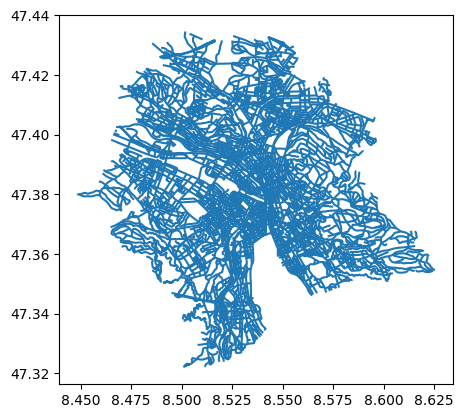

In [327]:
zhdf.plot()

In [328]:
zhdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2496 entries, 1 to 2545
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   id                        2496 non-null   object  
 1   snb_erlaeuterung          2496 non-null   object  
 2   str_name                  2496 non-null   object  
 3   geometry                  2496 non-null   geometry
 4   id                        2496 non-null   object  
 5   properties.str_st_id_ref  2496 non-null   int64   
dtypes: geometry(1), int64(1), object(4)
memory usage: 136.5+ KB


---

# Prüfen doppelte Streetkey in Wikidata

🧐 reagieren sollten hier Werte auftauchen

In [329]:
wikidf[wikidf["streetkey.value"].duplicated()]

,streetkey.type,streetkey.value,nativename.xml:lang,nativename.type,nativename.value


In [330]:
wikidf[wikidf["nativename.value"].duplicated()]

,streetkey.type,streetkey.value,nativename.xml:lang,nativename.type,nativename.value
90,literal,10249467,de-ch,literal,Emilie-Kempin-Spyri-Weg


# offizielle Daten - Wikidata zusammentragen

In [331]:
wikidfn = wikidf.set_index('streetkey.value').sort_index(axis="index")

In [332]:
wikidfn.head()

,streetkey.type,nativename.xml:lang,nativename.type,nativename.value
streetkey.value,,,,
1,literal,de-ch,literal,Aargauerstrasse
2,literal,de-ch,literal,Abeggweg
3,literal,de-ch,literal,Abendweg
4,literal,de-ch,literal,Achermannweg
5,literal,de-ch,literal,Ackermannstrasse


Zusammenführen der beiden Dataframes

In [333]:
joindf = pd.concat([zhdf, wikidfn], axis=1)

In [335]:
joindf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2525 entries, 1 to 10249467
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   id                        2496 non-null   object  
 1   snb_erlaeuterung          2496 non-null   object  
 2   str_name                  2496 non-null   object  
 3   geometry                  2496 non-null   geometry
 4   id                        2496 non-null   object  
 5   properties.str_st_id_ref  2496 non-null   float64 
 6   streetkey.type            2513 non-null   object  
 7   nativename.xml:lang       2513 non-null   object  
 8   nativename.type           2513 non-null   object  
 9   nativename.value          2513 non-null   object  
dtypes: float64(1), geometry(1), object(8)
memory usage: 217.0+ KB


# Prüfen Vorkommen offizielle Daten - Wikidata

  
Jeweils die nan-Werte betrachten

🧐 Strassen die im Strassenverzeichnis sind aber nicht in Wikidata:

In [336]:
joindf[joindf["nativename.value"].isna()]

,id,snb_erlaeuterung,str_name,geometry,id,properties.str_st_id_ref,streetkey.type,nativename.xml:lang,nativename.type,nativename.value
1369,sv_str_lin.8237,"Benannt nach der Maschinenfabrik Oerlikon, abg...",MFO-Park,"MULTILINESTRING ((8.54021 47.41161, 8.54023 47...",sv_str_verz.4729,1.0,NaN,NaN,NaN,NaN
2516,sv_str_lin.6028,"Die A1, d. h. Autobahn 1, verbindet als West-O...",A1,"MULTILINESTRING ((8.54947 47.43000, 8.54989 47...",sv_str_verz.5784,1.0,NaN,NaN,NaN,NaN
2517,sv_str_lin.8370,Der A1H ist der Autobahnzubringer Zürich-Hardt...,A1H,"MULTILINESTRING ((8.46893 47.40294, 8.46907 47...",sv_str_verz.5785,1.0,NaN,NaN,NaN,NaN
2518,sv_str_lin.7790,Der A1L ist der Autobahnzubringer Zürich-Lette...,A1L,"MULTILINESTRING ((8.56073 47.40479, 8.56085 47...",sv_str_verz.5786,1.0,NaN,NaN,NaN,NaN
2519,sv_str_lin.6657,"Die A3, d. h. Autobahn 3, verläuft auf der Str...",A3,"MULTILINESTRING ((8.52294 47.33732, 8.52272 47...",sv_str_verz.5787,1.0,NaN,NaN,NaN,NaN
2520,sv_str_lin.7300,Der A3W ist der Autobahnzubringer Zürich-Wiedi...,A3W,"MULTILINESTRING ((8.52433 47.36837, 8.52415 47...",sv_str_verz.5788,1.0,NaN,NaN,NaN,NaN
2534,sv_str_lin.8426,Blumenname.,Lupinenweg,"MULTILINESTRING ((8.47521 47.41467, 8.47492 47...",sv_str_verz.5958,1.0,NaN,NaN,NaN,NaN
2535,sv_str_lin.7858,Benannt nach der alten Ortsgegend «am Nebelbac...,Nebelbachweg,"MULTILINESTRING ((8.57585 47.34977, 8.57615 47...",sv_str_verz.5959,1.0,NaN,NaN,NaN,NaN
2539,sv_str_lin.7476,Der Letzibach speist sich aus fünf Bächen im U...,Letzibachweg,"MULTILINESTRING ((8.49148 47.39008, 8.49182 47...",sv_str_verz.5891,1.0,NaN,NaN,NaN,NaN
2541,sv_str_lin.6955,"Flurname «Schwesternbungert», der auf das bena...",Schwesternbungertweg,"MULTILINESTRING ((8.56894 47.39581, 8.56906 47...",sv_str_verz.5892,1.0,NaN,NaN,NaN,NaN


🧐 Strassen die in Wikidata sind aber nicht im Strassenverzeichnis:

In [338]:
joindf[joindf["str_name"].isna()]

,id,snb_erlaeuterung,str_name,geometry,id,properties.str_st_id_ref,streetkey.type,nativename.xml:lang,nativename.type,nativename.value
85,NaN,NaN,NaN,None,NaN,NaN,literal,de-ch,literal,Annemarie-Schwarzenbach-Weg
97,NaN,NaN,NaN,None,NaN,NaN,literal,de-ch,literal,Arnold-Kübler-Strasse
324,NaN,NaN,NaN,None,NaN,NaN,literal,de-ch,literal,Bührlestrasse
450,NaN,NaN,NaN,None,NaN,NaN,literal,de-ch,literal,Einsteinbrücke
658,NaN,NaN,NaN,None,NaN,NaN,literal,de-ch,literal,Gertrud-Kurz-Strasse
808,NaN,NaN,NaN,None,NaN,NaN,literal,de-ch,literal,Hauswiesenweg
905,NaN,NaN,NaN,None,NaN,NaN,literal,de-ch,literal,Holunderhof
1039,NaN,NaN,NaN,None,NaN,NaN,literal,de-ch,literal,Juchweg
1364,NaN,NaN,NaN,None,NaN,NaN,literal,de-ch,literal,Meret-Oppenheim-Weg
1456,NaN,NaN,NaN,None,NaN,NaN,literal,de-ch,literal,Niklaus-Meienberg-Weg


# Prüfen Namen offizielle Daten - Wikidata

In [339]:
joindf.head()

,id,snb_erlaeuterung,str_name,geometry,id,properties.str_st_id_ref,streetkey.type,nativename.xml:lang,nativename.type,nativename.value
1,sv_str_lin.8302,Benannt zu Ehren des Nachbarkantons Aargau.,Aargauerstrasse,"MULTILINESTRING ((8.50280 47.39253, 8.50241 47...",sv_str_verz.3692,1.0,literal,de-ch,literal,Aargauerstrasse
2,sv_str_lin.7312,"Abegg: Unternehmerfamilie aus Küsnacht (ZH), a...",Abeggweg,"MULTILINESTRING ((8.53463 47.39370, 8.53397 47...",sv_str_verz.3693,1.0,literal,de-ch,literal,Abeggweg
3,sv_str_lin.7291,"Ein gegen Sonnenuntergang («Abend»), d. h. geg...",Abendweg,"MULTILINESTRING ((8.52970 47.34963, 8.52945 47...",sv_str_verz.3694,1.0,literal,de-ch,literal,Abendweg
4,sv_str_lin.8355,Arnold Achermann (1890-1970): Erster Präsident...,Achermannweg,"MULTILINESTRING ((8.54509 47.40715, 8.54514 47...",sv_str_verz.3695,1.0,literal,de-ch,literal,Achermannweg
5,sv_str_lin.6966,Angehörige der Familie Ackermann wirkten von 1...,Ackermannstrasse,"MULTILINESTRING ((8.56345 47.37621, 8.56377 47...",sv_str_verz.3696,1.0,literal,de-ch,literal,Ackermannstrasse


Die Werte in den Spalten vergleichen

In [384]:
joindffull = joindf.dropna()

In [385]:
joindffullmatch = np.where(joindffull['str_name'] == joindffull['nativename.value'],False, True)

🧐 Strassen die in Wikidata und Strassenverzeichnis unterschiedliche Namen haben:

In [386]:
joindffull[joindffullmatch]

,id,snb_erlaeuterung,str_name,geometry,id,properties.str_st_id_ref,streetkey.type,nativename.xml:lang,nativename.type,nativename.value,Name_Matching
